In [28]:
import numpy as np
import pandas as pd

In [29]:
import pickle

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [32]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi")

<Experiment: artifact_location='/home/baothai/Documents/taxi_project/week 2/mlflow/mlruns/1', creation_time=1687791896366, experiment_id='1', last_update_time=1687791896366, lifecycle_stage='active', name='nyc-taxi', tags={}>

In [33]:
df = pd.read_parquet('green_tripdata_2023-01.parquet')
df.shape

(68211, 20)

In [36]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.90,1.0,0.5,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.70,1.0,0.5,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.20,1.0,0.5,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.50,0.5,1.5,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.00,0.5,1.5,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,None,NaN,49,62,NaN,4070.82,15.70,0.0,0.0,0.00,0.0,None,1.0,16.70,NaN,NaN,NaN
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,None,NaN,10,205,NaN,2.14,4.41,0.0,0.0,0.00,0.0,None,1.0,5.41,NaN,NaN,NaN
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,None,NaN,66,37,NaN,3.44,16.53,0.0,0.0,3.51,0.0,None,1.0,21.04,NaN,NaN,NaN
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,None,NaN,225,189,NaN,3.03,14.98,0.0,0.0,3.20,0.0,None,1.0,19.18,NaN,NaN,NaN


In [37]:
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,...,0.5,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75,11.016667
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,...,0.5,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00,6.766667
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,...,0.5,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00,6.333333
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,...,1.5,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00,5.816667
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,...,1.5,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00,5.966667


In [38]:
df.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
count,68211.000000,68211,68211,63887.000000,68211.000000,68211.000000,63887.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,63887.000000,63877.000000,63887.000000,68211.000000
mean,1.863028,2023-01-16 20:10:55.679524096,2023-01-16 20:29:01.515767040,1.117160,98.549735,138.429901,1.315870,8.114852,16.603545,0.825431,0.588340,2.139012,0.169627,0.951625,21.789377,1.373613,1.021933,0.726748,18.097271
min,1.000000,2009-01-01 20:21:27,2009-01-02 11:07:31,1.000000,1.000000,1.000000,0.000000,0.000000,-70.000000,-2.500000,-0.500000,-10.500000,0.000000,-1.000000,-71.500000,1.000000,1.000000,-2.750000,0.000000
25%,2.000000,2023-01-09 11:59:47.500000,2023-01-09 12:16:37.500000,1.000000,74.000000,74.000000,1.000000,1.110000,9.300000,0.000000,0.500000,0.000000,0.000000,1.000000,12.900000,1.000000,1.000000,0.000000,7.216667
50%,2.000000,2023-01-17 08:40:42,2023-01-17 08:56:38,1.000000,75.000000,138.000000,1.000000,1.850000,13.500000,0.000000,0.500000,1.600000,0.000000,1.000000,17.900000,1.000000,1.000000,0.000000,11.400000
75%,2.000000,2023-01-24 15:52:30,2023-01-24 16:06:56,1.000000,129.000000,219.000000,1.000000,3.210000,19.800000,1.000000,0.500000,3.330000,0.000000,1.000000,26.150000,2.000000,1.000000,2.750000,17.483333
max,2.000000,2023-02-01 03:10:05,2023-02-01 17:27:05,99.000000,265.000000,265.000000,9.000000,120098.840000,490.000000,12.500000,2.750000,222.220000,36.050000,1.000000,491.000000,5.000000,2.000000,2.750000,1439.883333
std,0.343820,NaN,NaN,1.372913,61.244314,76.761311,0.979054,585.105955,13.470121,1.269904,0.385819,3.052710,1.099789,0.196875,15.457115,0.508039,0.146465,1.212836,74.925631


In [39]:
df = df[(df.duration >= 1) & (df.duration <= 60)]
df.shape

(65946, 21)

In [40]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str)

/tmp/ipykernel_5563/138176157.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [41]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [42]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [43]:
target = 'duration'
y_train = df[target].values

In [44]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.060351532330623

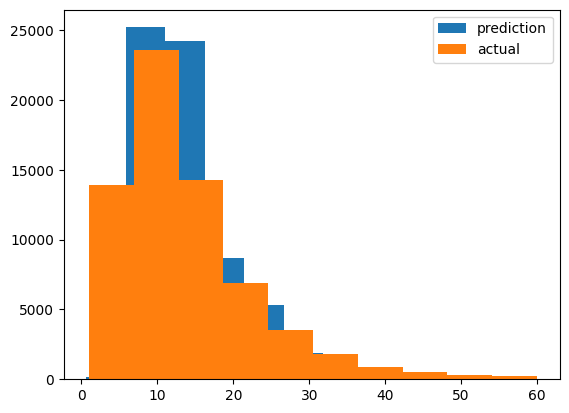

In [45]:
plt.hist(y_pred, label='prediction')
plt.hist(y_train, label='actual')

plt.legend()

In [46]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [47]:
df_train = read_dataframe('green_tripdata_2023-01.parquet')
df_val = read_dataframe('green_tripdata_2023-02.parquet')

In [48]:
len(df_train), len(df_val)

(65946, 62574)

In [49]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [50]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [51]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [52]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.037730646649732

In [53]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [54]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

8.231436941224935

In [56]:
with mlflow.start_run():
    mlflow.set_tag("developer", "baothai")
    mlflow.log_param("train_data_path", "./green_tripdata_2023-01.parquet")
    mlflow.log_param("val_data_path", "./green_tripdata_2023-02.parquet")
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

In [57]:
import xgboost as xgb

In [58]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [59]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [60]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=Trials()
)

In [63]:
params = {
    'learning_rate':	0.07463604656252634,
    'max_depth':	20,
    'min_child_weight':	1.9623946880239287,
    'objective'	: 'reg:linear',
    'reg_alpha'	:0.1529883297372037,
    'reg_lambda'	:0.0037277920895706514,
    'seed':	42
}
mlflow.xgboost.autolog()
booster = xgb.train(
    params = params,
    dtrain = train,
    num_boost_round=1000,
    evals=[(valid, "validation")],
    early_stopping_rounds=50
)

2023/06/26 23:25:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b0d2f9202b1a4b8996cb995bc09edfb6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[23:25:03] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.32453
[1]	validation-rmse:14.33177
[2]	validation-rmse:13.42350
[3]	validation-rmse:12.59431
[4]	validation-rmse:11.83705
[5]	validation-rmse:11.14670
[6]	validation-rmse:10.52080
[7]	validation-rmse:9.95046
[8]	validation-rmse:9.43698
[9]	validation-rmse:8.96927
[10]	validation-rmse:8.55108
[11]	validation-rmse:8.17139
[12]	validation-rmse:7.83374
[13]	validation-rmse:7.52894
[14]	validation-rmse:7.25771
[15]	validation-rmse:7.01636
[16]	validation-rmse:6.80410
[17]	validation-rmse:6.61377
[18]	validation-rmse:6.44519
[19]	validation-rmse:6.29901
[20]	validation-rmse:6.16861
[21]	validation-rmse:6.05504
[22]	validation-rmse:5.95347
[23]	validation-rmse:5.86661
[24]	validation-rmse:5.78920
[25]	validation-rmse:5.72123
[26]	validation-rmse:5.66191
[27]	validation-rmse:5.61136
[28]	validation-rmse:5.56554
[29]	validation-rmse:5.52451
[30]	validatio

2023/06/26 23:26:05 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
